In [16]:
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import json
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

from utils_dataloaders import *
from utils_training import *

##### set dataframe display options 
# show decimal format (not scientific notation)
pd.options.display.float_format = '{:.4f}'.format

# display all columns
pd.set_option('display.max_columns', None)

In [2]:

patches_geojson = [r'../data/howevalley/hv_patches_256_50.geojson', 
                   r'../data/sonora/sonora_patches_256_50.geojson', 
                   r'../data/warren/patches_256_50.geojson']


labels_path = glob.glob(r'../data/warren/*labels.csv')[0]
areas_path = glob.glob(r'../data/warren/*areas.csv')[0]

hardin_labels_path = glob.glob(r'../data/hardin/*labels.csv')[0]
hardin_areas_path = glob.glob(r'../data/hardin/*areas.csv')[0]

In [14]:
all_patches_path = r'../data/all_patches.geojson'

gdf = gpd.read_file(patches_geojson[0])
for patches in patches_geojson[1:]:
    gdf2 = gpd.read_file(patches)
    gdf = pd.concat([gdf, gdf2])

gdf.to_file(all_patches_path, driver='GeoJSON')

patch_ids = gdf['patch_id'].to_list()

In [12]:
all_counts_path = r'../data/all_counts.csv'

df_counts = pd.read_csv(labels_path)
df_counts = pd.concat([df_counts, pd.read_csv(hardin_labels_path)])

df_counts.to_csv(all_counts_path, index=False)

In [13]:
all_areas_path = r'../data/all_areas.csv'

df_areas = pd.read_csv(areas_path)
df_areas = pd.concat([df_areas, pd.read_csv(hardin_areas_path)])

df_areas.to_csv(all_areas_path, index=False)

In [17]:

# path to JSON metadata
geo_meta_path = r'../data/warren/geology.json'

##### create custom color map from GeoTIFF metadata JSON
# NOTE: these are standard colors from Kentucky Geological Survey
with open(geo_meta_path, 'r') as meta:
    geo_meta = json.load(meta)

colors = {'af1': '#636566', 
          'Qal': '#fdf5a4', 
          'Qaf': '#ffa1db', 
          'Qat': '#f9e465', 
          'Qc': '#d6c9a7', 
          'Qca': '#c49d83', 
          'Qr': '#b0acd6'}


In [60]:
def plot_class_distributions(patch_id_list, patch_count_path, patch_area_path, colors=colors):

    ##### calculate counts of occurrences
    df_count = pd.read_csv(patch_count_path)
    df_count = df_count.loc[df_count['patch_id'].isin(patch_id_list)]
    counts = df_count.iloc[:, 1:].sum(axis=0)
    counts = pd.DataFrame(counts) 

    ##### calculate areas in patches
    df_area = pd.read_csv(patch_area_path)
    df_area = df_area.loc[df_area['patch_id'].isin(patch_id_list)]
    df_area_long = df_area.iloc[:, 1:].melt(var_name='Geologic Map Unit', value_name='Proportion')

    ##### plot class distributions
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))

    # counts...
    sns.barplot(ax=ax[0], data=counts, x=counts.index, y=0, hue=counts.index, palette=colors, edgecolor='k', linewidth=0.5)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Counts')
    ax[0].set_title('Class Occurrence per Patch', style='italic')

    # areas...
    sns.boxplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', 
                showfliers=False, fill=False, color='k', width=0.5, linewidth=1)
    
    sns.stripplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', hue='Geologic Map Unit', palette=colors,
                  jitter=True, edgecolor='k', linewidth=0.2, alpha=0.03, facecolor='#3A6D8C', zorder=0)
    
    ax[1].set_xlabel('')
    ax[1].set_ylabel('Proportion')
    ax[1].set_title('Exposed Area per Patch', style='italic')

    plt.ylim(0,1)
    plt.show()

    return fig

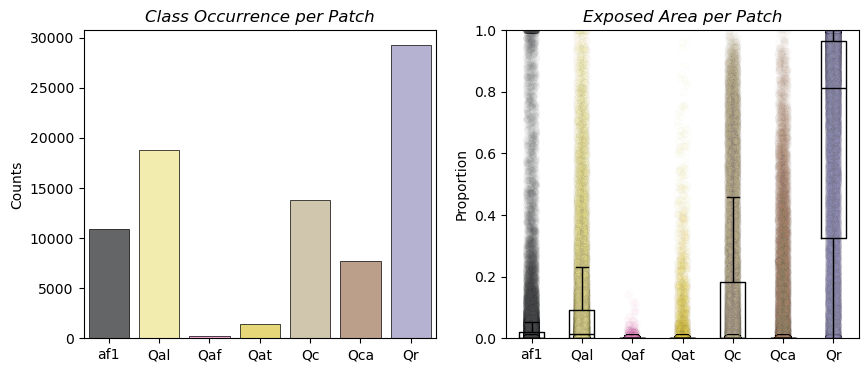

In [61]:
fig = plot_class_distributions(patch_ids, all_counts_path, all_areas_path)
fig.savefig(r'../data/class_distribution.jpg')
plt.show(fig)


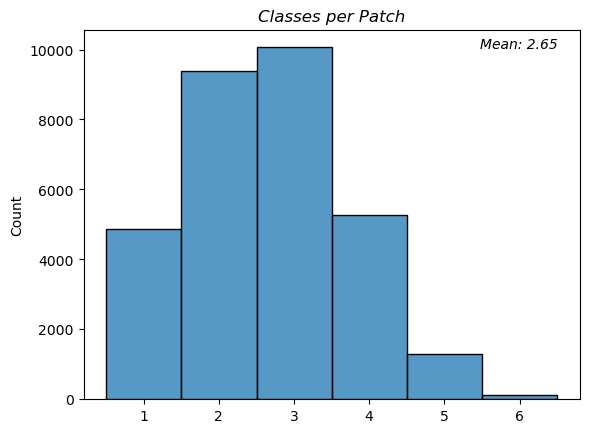

In [91]:
avg = df_counts.iloc[:, 1:].sum(axis=1).mean()

fig, ax = plt.subplots()

sns.histplot(df_counts.iloc[:, 1:].sum(axis=1), discrete=True, ax=ax)
ax.text(x=0.8, y=0.95, s=f"Mean: {round(avg, 2)}", transform=ax.transAxes, style='italic')
ax.set_title('Classes per Patch', style='italic')
plt.show()